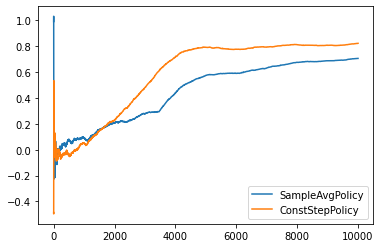

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class TenArmTestBed():
    def __init__(self, k=10):
        self.q_star_a = np.zeros((k)) #np.random.normal(loc=0, scale=1, size=k)
        self.k = k
        
    def _update(self):
        self.q_star_a += np.random.normal(loc=0, scale=0.01, size=self.k)
    
    def _sample(self, a):
        return np.random.normal(loc=self.q_star_a[a])
    
    def step(self, a, update=True):
        if update:
            self._update()
        return self._sample(a)
    
    @property
    def act_dim(self):
        return self.k

class Agent():
    def __init__(self, epsilon=0.1, policy=None, act_dim=10):
        self.epsilon = epsilon
        self.Q_a = np.zeros(act_dim)
        self.N_a = np.zeros(act_dim)
        self.policy = policy(self)
        self.act_dim = act_dim
        
    def act(self):
        if np.random.rand() >= self.epsilon:
            return np.argmax(self.Q_a)
        else:
            return np.random.randint(self.act_dim)
        
    def observe(self, act, reward):
        self.policy.update(act, reward)

class SampleAvgPolicy():
    def __init__(self, agent):
        self.agent = agent
    
    def update(self, A, R):
        self.agent.N_a[A] += 1
        self.agent.Q_a[A] += 1 / self.agent.N_a[A] * (R - self.agent.Q_a[A])
        
class ConstStepPolicy():
    def __init__(self, agent, alpha=0.1):
        self.agent = agent
        self.alpha = alpha
    
    def update(self, A, R):
        self.agent.N_a[A] += 1
        self.agent.Q_a[A] += self.alpha * (R - self.agent.Q_a[A])
        
env = TenArmTestBed()
epsilon = 0.1
agent1 = Agent(epsilon=0.1, policy=SampleAvgPolicy, act_dim=env.act_dim)
agent2 = Agent(epsilon=0.1, policy=ConstStepPolicy, act_dim=env.act_dim)
env_update = True
rewards1 = []
rewards2 = []

for t in range(1, 10001):
    act1 = agent1.act()
    act2 = agent2.act()
    reward1 = env.step(act1, update=True)
    reward2 = env.step(act2, update=False)
    agent1.observe(act1, reward1)
    agent2.observe(act2, reward2)
    rewards1.append(reward1)
    rewards2.append(reward2)
    
mean_rewards1 = [rewards1[0]]
mean_rewards2 = [rewards2[0]]
for i in range(1, len(rewards1)):
    mean_rewards1.append(mean_rewards1[-1] + 1. / (i+1) * (rewards1[i] - mean_rewards1[-1]))
    mean_rewards2.append(mean_rewards2[-1] + 1. / (i+1) * (rewards2[i] - mean_rewards2[-1]))
plt.plot(mean_rewards1)
plt.plot(mean_rewards2)
plt.legend(['SampleAvgPolicy', 'ConstStepPolicy'])